# Demo of Autocoders and Variational Autoencoders

This notebook is just a demo to show how an autoencoder can be applied to image data. Here the MNIST dataset from the tensorflow datasets is used for the demo.

# Setting up the environment

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Loading the data

In [ ]:
(mnist_train_original, mnist_validate_original, mnist_test_original), info = tfds.load(
    name='mnist',
    split=["train[80%:]", "train[:80%]", "test"],
    with_info=True,
    as_supervised=True
)
info

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.1,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)

### Data preprocessing

In [ ]:
def convert_float(image):
  """
  This also normalized between 0 and 1
  """
  new_image = tf.image.convert_image_dtype(image, dtype=tf.float32)
  return new_image, new_image

In [ ]:
mnist_train = mnist_train_original.map(lambda x, _ : convert_float(x))
mnist_train = mnist_train.cache().shuffle(60000)

mnist_validate = mnist_validate_original.map(lambda x, _ : convert_float(x))
mnist_validate = mnist_validate.cache()

mnist_test = mnist_test_original.map(lambda x, _ : convert_float(x))
mnist_test = mnist_test.cache()

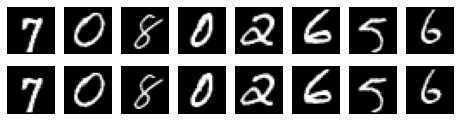

In [ ]:
def render_data():

  plt.figure(figsize=(8, 2))
  index = 1

  for image_in, image_out in mnist_train.take(8):
    plt.subplot(2, 8, index)
    plt.axis('off')
    plt.imshow(image_in[:, :, 0], cmap='gray')

    plt.subplot(2, 8, index+8)
    plt.axis('off')
    plt.imshow(image_out[:, :, 0], cmap='gray')

    index += 1

render_data()

# Autoencoder model

In [ ]:
class Autoencoder(tf.keras.Model):
  def __init__(self, latentdim):
    super().__init__()

    self.latentdim = latentdim

    # Encoder
    self.reshape_input = layers.Reshape((784,))
    self.encode_input = layers.Dense(512, activation='relu')
    self.encode_latent = layers.Dense(latentdim, activation='relu')

    # Decoder
    self.decode_latent = layers.Dense(512, activation='relu')
    self.decode_output = layers.Dense(784, activation='relu')
    self.decode_reshape = layers.Reshape((28, 28, 1))

    self.build_graph()


  def build_graph(self):
    input_shape = (28, 28, 1)
    self.build((None,) + input_shape)
    input_layers = layers.Input(shape=input_shape)
    _ = self.call(input_layers)


  def encode(self, x):
    x = self.reshape_input(x)
    x = self.encode_input(x)
    x = self.encode_latent(x)
    return x


  def decode(self, x):
    x = self.decode_latent(x)
    x = self.decode_output(x)
    x = self.decode_reshape(x)
    return x


  def call(self, x):
    z = self.encode(x)
    y = self.decode(z)
    return y

In [ ]:
model_ae = Autoencoder(32)
model_ae.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                16416     
_________________________________________________________________
dense_2 (Dense)              (None, 512)               16896     
_________________________________________________________________
dense_3 (Dense)              (None, 784)               402192    
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
Total params: 837,424
Trainable params: 837,424
Non-trainable params: 0
_________________________________________________

### Model *training*

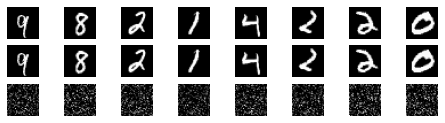

In [ ]:
# Plot predicted image 
def render_prediction():
  plt.figure(figsize=(8, 2))
  index = 1

  for image_in, image_out in mnist_train.take(8):
    plt.subplot(3, 8, index)
    plt.axis('off')
    plt.imshow(image_in[:, :, 0], cmap='gray')

    plt.subplot(3, 8, index+8)
    plt.axis('off')
    plt.imshow(image_out[:, :, 0], cmap='gray')

    plt.subplot(3, 8, index+16)
    plt.axis('off')
    predictions = model_ae.predict(
        np.array([image_in])
    )[0]
    plt.imshow(predictions[:, :, 0], cmap='gray')

    index += 1

render_prediction()

In [ ]:
# Train the model

model_ae.compile(optimizer='rmsprop',
                 loss='binary_crossentropy'
                 )

history_ae = model_ae.fit(
    mnist_train.batch(256),
    epochs=50,
    validation_data=mnist_test.batch(256))

Epoch 1/50
47/47 [==============================] - 2s 31ms/step - loss: 0.5089 - val_loss: 0.3616
Epoch 2/50
47/47 [==============================] - 0s 7ms/step - loss: 0.3482 - val_loss: 0.3225
Epoch 3/50
47/47 [==============================] - 0s 7ms/step - loss: 0.3206 - val_loss: 0.3129
Epoch 4/50
47/47 [==============================] - 0s 7ms/step - loss: 0.3063 - val_loss: 0.3192
Epoch 5/50
47/47 [==============================] - 0s 7ms/step - loss: 0.2939 - val_loss: 0.3399
Epoch 6/50
47/47 [==============================] - 0s 7ms/step - loss: 0.2784 - val_loss: 0.2589
Epoch 7/50
47/47 [==============================] - 0s 7ms/step - loss: 0.2646 - val_loss: 0.2837
Epoch 8/50
47/47 [==============================] - 0s 7ms/step - loss: 0.2542 - val_loss: 0.2618
Epoch 9/50
47/47 [==============================] - 0s 7ms/step - loss: 0.2450 - val_loss: 0.2354
Epoch 10/50
47/47 [==============================] - 0s 7ms/step - loss: 0.2445 - val_loss: 0.2352
Epoch 11/50
47/47 

### Loss curve of Autoencoder

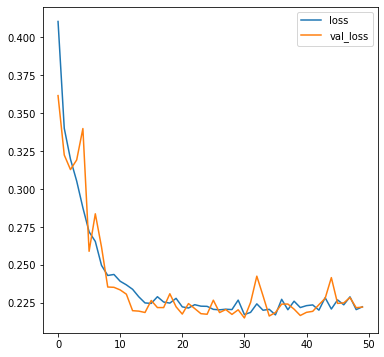

In [ ]:
plt.figure(figsize=(6,6))

plt.plot(history_ae.history['loss'], label='loss')
plt.plot(history_ae.history['val_loss'], label='val_loss')
plt.legend()
plt.plot()
plt.show()

### Autoencoder model predictions

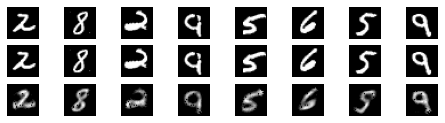

In [ ]:
render_prediction()

# Variational Autoencoder

In [ ]:
!pip install git+https://github.com/AI-Guru/ngdlm.git
from ngdlm import models as ngdlmodels
from ngdlm import utils as ngdlutils
from tensorflow.keras.datasets import mnist
tf.compat.v1.disable_eager_execution()

  Cloning https://github.com/AI-Guru/ngdlm.git to /tmp/pip-req-build-3ef964dc
  Running command git clone -q https://github.com/AI-Guru/ngdlm.git /tmp/pip-req-build-3ef964dc
  Created wheel for ngdlm: filename=ngdlm-0.0.3-py2.py3-none-any.whl size=32027 sha256=d70f012579e25a4310c82bbf314a9db956ae03f546759df3ecfab807d84c20cc
  Stored in directory: /tmp/pip-ephem-wheel-cache-42spdgqs/wheels/93/06/27/e156acb49f475c364c3c9fa4ad4ab7bfa38808bff5bf9c4647
Successfully built ngdlm


In [ ]:
(x_input_train, _), (x_input_test, y_input_test) = mnist.load_data()

x_input_train = x_input_train.astype('float32') / 255.0
x_input_test = x_input_test.astype('float32') / 255.0

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
print(x_input_train.shape)
print(x_input_test.shape)

(60000, 28, 28)
(10000, 28, 28)


### Building the Variational Autoencoder

In [ ]:
# Latent dim
latentdim = 2

# Encoder
encoder_input = layers.Input(shape=(28, 28))
h = layers.Reshape((784,))(encoder_input)
encoder_output = layers.Dense(512, activation='relu')(h)
encoder = Model(encoder_input, encoder_output)

# Decoder
decoder_input = layers.Input(shape=(latentdim,))
h = layers.Dense(512, activation='relu')(decoder_input)
h = layers.Dense(784, activation='relu')(h)
decoder_output = layers.Reshape((28, 28))(h)
decoder = Model(decoder_input, decoder_output)

model_vae = ngdlmodels.VAE(
    encoder, 
    decoder,
    latent_dim = latentdim)

model_vae.summary()

Encoder:
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 784)          0           input_1[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 512)          401920      reshape_2[0][0]                  
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_4[0][0]                    
___________________________________________________________________________________

### Train the Variational Autoencoder

In [ ]:
model_vae.compile(optimizer='rmsprop',
                  loss='binary_crossentropy')

history_vae = model_vae.fit(
    x_input_train,
    x_input_train,
    epochs=100,
    batch_size=512,
    shuffle=True,
    validation_data = (x_input_test, 
                       x_input_test)
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 1s 16us/sample - loss: 0.4364 - val_loss: 0.3987
Epoch 2/100
 5632/60000 [=>............................] - ETA: 0s - loss: 0.3986

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


60000/60000 [==============================] - 1s 11us/sample - loss: 0.3933 - val_loss: 0.3845
Epoch 3/100
60000/60000 [==============================] - 1s 10us/sample - loss: 0.3772 - val_loss: 0.3689
Epoch 4/100
60000/60000 [==============================] - 1s 11us/sample - loss: 0.3684 - val_loss: 0.3652
Epoch 5/100
60000/60000 [==============================] - 1s 11us/sample - loss: 0.3569 - val_loss: 0.3545
Epoch 6/100
60000/60000 [==============================] - 1s 11us/sample - loss: 0.3479 - val_loss: 0.3377
Epoch 7/100
60000/60000 [==============================] - 1s 10us/sample - loss: 0.3387 - val_loss: 0.3387
Epoch 8/100
60000/60000 [==============================] - 1s 11us/sample - loss: 0.3305 - val_loss: 0.3186
Epoch 9/100
60000/60000 [==============================] - 1s 10us/sample - loss: 0.3139 - val_loss: 0.3073
Epoch 10/100
60000/60000 [==============================] - 1s 10us/sample - loss: 0.3059 - val_loss: 0.3041
Epoch 11/100
60000/60000 [=============

### Loss curve of variational autoencoder

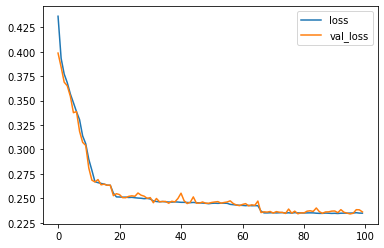

In [ ]:
ngdlutils.render_history(history_vae)

### Render predictions of Variational Autoencoder

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


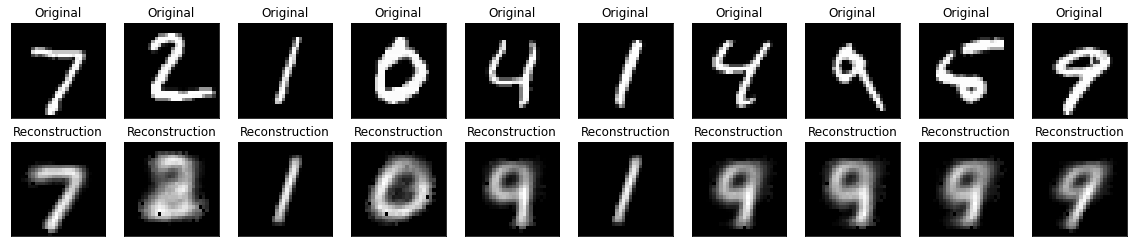

In [ ]:
ngdlutils.render_image_reconstructions(
    model_vae,
    x_input_test[0:10]
)

# Render the input to the latent space

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


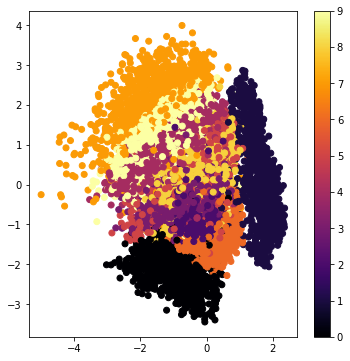

In [ ]:
ngdlutils.render_encodings(
    model_vae.encoder,
    x_input_test,
    y_input_test
)